<a href="https://colab.research.google.com/github/kartik481/COVID19-Detection-using-X-Ray/blob/main/Detection_of_COVID_19_using_X_RAY_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
## Loading X_ray image dataset from Drive
TRAIN_PATH="drive/MyDrive/Dataset/Train"  ## Training Data
VAL_PATH="drive/MyDrive/Dataset/Test"     ## validation Data

In [ ]:
## Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

In [ ]:
## Building a simple CNN Model using relu activation function
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid')) ## Using sigmoid as output activation func.

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
## Detailed summary of model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_24 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_25 (Activation)   (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 52, 52, 64)       

In [ ]:
#Generating new Image to increase to increase train Dataset

train_datagen= image.ImageDataGenerator(   
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen= image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary'
)

Found 440 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'COVID-19': 0, 'Normal': 1}

In [ ]:
#Generating new Image to increase to increase Validation Dataset
validation_generator=test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary'
)

Found 66 images belonging to 2 classes.


In [ ]:
## fitting the model
hist=model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=3
)

Epoch 1/15
8/8 [==============================] - 6s 723ms/step - loss: 0.1989 - accuracy: 0.9141 - val_loss: 0.1420 - val_accuracy: 0.9792
Epoch 2/15
8/8 [==============================] - 5s 683ms/step - loss: 0.2539 - accuracy: 0.8828 - val_loss: 0.1348 - val_accuracy: 0.9583
Epoch 3/15
8/8 [==============================] - 5s 659ms/step - loss: 0.1504 - accuracy: 0.9667 - val_loss: 0.1420 - val_accuracy: 0.9583
Epoch 4/15
8/8 [==============================] - 5s 617ms/step - loss: 0.1846 - accuracy: 0.9583 - val_loss: 0.1057 - val_accuracy: 0.9792
Epoch 5/15
8/8 [==============================] - 5s 630ms/step - loss: 0.1930 - accuracy: 0.9297 - val_loss: 0.1562 - val_accuracy: 0.9583
Epoch 6/15
8/8 [==============================] - 6s 713ms/step - loss: 0.1483 - accuracy: 0.9609 - val_loss: 0.1403 - val_accuracy: 0.9583
Epoch 7/15
8/8 [==============================] - 5s 657ms/step - loss: 0.1548 - accuracy: 0.9833 - val_loss: 0.0532 - val_accuracy: 0.9792
Epoch 8/15
8/8 [====

In [ ]:
## saving the model
model.save("model_adv.h5")

In [ ]:
## checking model performance on train set
model.evaluate(train_generator)

28/28 [==============================] - 15s 520ms/step - loss: 0.0821 - accuracy: 0.9795


[0.08212566375732422, 0.9795454740524292]

In [ ]:
## checking model performance on train set
model.evaluate(validation_generator)

5/5 [==============================] - 1s 206ms/step - loss: 0.1026 - accuracy: 0.9697


[0.10258007794618607, 0.9696969985961914]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)

5/5 [==============================] - 1s 250ms/step


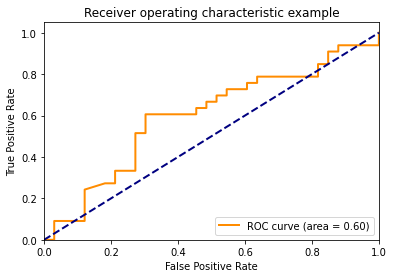

In [ ]:
#Creating the ROC curve and AUC, we’ll need to compute the false-positive rate and the true-positive rate:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

TESTING IMAGES

In [ ]:
models=load_model('model_adv.h5')

In [ ]:
import os

In [ ]:
train_generator.class_indices

{'COVID-19': 0, 'Normal': 1}

In [ ]:
y_actual=[]
y_test=[]

In [ ]:
## Checking for sample model performance on test images(Normal ones)
for i in os.listdir("drive/MyDrive/Dataset/Test/Normal/"):
  img=image.load_img("drive/MyDrive/Dataset/Test/Normal/"+i,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  p=model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(1)


In [ ]:
## Checking for sample model performance on test images(actual Covid-19 ones)
for i in os.listdir("drive/MyDrive/Dataset/Test/COVID-19/"):
  img=image.load_img("drive/MyDrive/Dataset/Test/COVID-19/"+i,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  p=model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(0)


In [ ]:
y_actual=np.array(y_actual)
y_test=np.array(y_test)

In [ ]:
## Importing libraries to make confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
cm=confusion_matrix(y_actual,y_test)

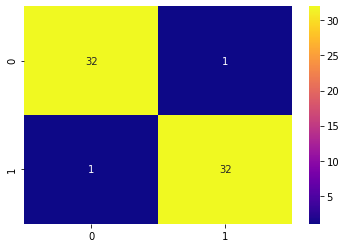

In [ ]:
## plotting a confusion matrix
sns.heatmap(cm,cmap="plasma",annot=True)